In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

# Wrangling and Transforming

We begin by taking a peek at the contents of our data file.
To do this, we open the file and examine the first few rows
({numref}`Chapter %s <ch:files>`):

In [2]:
from pathlib import Path

# Create a Path pointing to our data file
insp_path = Path() / 'data' / 'donkeys.csv'

with insp_path.open() as f:
    # Display first five lines of file
    for _ in range(5):
        print(f.readline(), end='')

BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt
3,<2,stallion,78,90,90,77,NA
2.5,<2,stallion,91,97,94,100,NA
1.5,<2,stallion,74,93,95,74,NA
3,<2,female,87,109,96,116,NA


Since the file is CSV formatted, we can easily read it into a data frame:

In [3]:
donkeys = pd.read_csv("donkeys.csv")
donkeys

,BCS,Age,Sex,Length,Girth,Height,Weight,WeightAlt
0,3.0,<2,stallion,78,90,90,77,NaN
1,2.5,<2,stallion,91,97,94,100,NaN
2,1.5,<2,stallion,74,93,95,74,NaN
...,...,...,...,...,...,...,...,...
541,2.5,10-15,stallion,103,118,103,174,NaN
542,3.0,2-5,stallion,91,112,100,139,NaN
543,3.0,5-10,stallion,104,124,110,189,NaN


Over 500 donkeys participated in the survey, and eight measurements were made on each donkey. According to the documentation, the granularity is a single donkey ({numref}`Chapter %s <ch:wrangling>`).
{numref}`Table %s <tbl:donkey-codebook>` provides descriptions of the eight features.

:::{table} Donkey Study Codebook
:name: tbl:donkey-codebook

| Feature        | Data Type | Feature Type      | Description                                                        |
|----------------|-----------|------------|--------------------------------------------------------|
|BCS    | float64 |  ordinal | Body Condition Score: from 1 (emaciated) through 3 (healthy) to 5 (obese) in increments of 0.5. |
| Age          | string |  ordinal | Age in years, under 2, 2-5, 5-10, 10-15, 15-20, and over 20 years. |
| Sex          | string | nominal | Sex categories: stallion, gelding, female.  |
| Length      | int64 | numeric | body length (cm) from front leg elbow to back of pelvis. |
| Girth       | int64 | numeric | body circumference (cm), measured just behind front legs. |
| Height | int64 | numeric | body height (cm) up to point where neck connects to back.     |
| Weight    |int64   | numeric | weight (kilogram).   |
| WeightAlt  |float64  | numeric | second weight measurement taken on a subset of donkeys.  |

:::



{numref}`Figure %s <fig:donkeyDiagram>` is a stylized representation of a donkey as a cylinder with neck and legs appended. Notice the height measurement includes the legs. The girth and length are the circumference and length of the cylinder. 

```{figure} donkeyDiagram.png
---
name: fig:donkeyDiagram
width: 400px
---
The cylinder shown here represents the body of a donkey. Girth is measured around the body just behind the front legs, height is measured from the ground to where the neck connects to the top of the back, and length is measured from the front elbow to the back of the pelvis. 
```

Our next step is to perform some quality checks on the data. In the previous section, we listed a few potential quality concerns based on scope. Next, we check the quality of the measurements and their distributions.

Let's start by comparing the two weight measurements made on the subset of donkeys to check on the consistency of the scale. We make a histogram of the difference between these two measurements for the 31 donkeys that were weighed twice: 

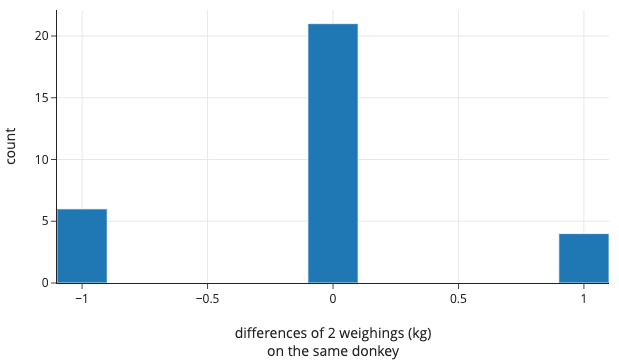

In [5]:
donkeys['difference'] = donkeys['WeightAlt'] - donkeys['Weight']

px.histogram(donkeys, x='difference', nbins=15,
   labels=dict(difference='differences of 2 weighings (kg)<br>on the same donkey'),
             width=350, height=250)

The measurements are all within 1 kg of each other, and the majority are exactly the same (to the nearest kilogram). This gives us confidence in the accuracy of the measurements. 

Next, we look for unusual values in the body condition score: 

In [6]:
donkeys['BCS'].value_counts()

3.0    307
2.5    135
3.5     55
      ... 
1.5      5
4.5      1
1.0      1
Name: BCS, Length: 8, dtype: int64

From this output, we see that there's only one emaciated (BCS=1) and one obese (BCS=4.5) donkey.
Let's look at the complete records for these two donkeys:

In [8]:
donkeys[(donkeys['BCS'] == 1.0) | (donkeys['BCS'] == 4.5)]

,BCS,Age,Sex,Length,...,Height,Weight,WeightAlt,difference
291,4.5,10-15,female,107,...,106,227,NaN,NaN
445,1.0,>20,female,97,...,102,115,NaN,NaN


Since these BCS values are extreme, we want to be cautious about including these two donkeys in our analysis. Since we have only one donkey in each of these extreme categories, our model might well not extend to donkeys with BCS of 1 or 4.5. So we remove these two records from the data frame, and note that our analysis may not extend to emaciated or obese donkeys. In general, we exercise caution in dropping records from a data frame. Later, we may also decide to remove the five donkeys with a score of 1.5, if they appear anomalous in our analysis, but for now, we keep them in our data frame. We need good reasons for their exclusion, document our action, and keep the number of excluded observations low so that we avoid overfitting a model because we dropped any record that disagreed with the model. 

We remove these two outliers next:

In [9]:
def remove_bcs_outliers(donkeys):
    return donkeys[(donkeys['BCS'] >= 1.5) & (donkeys['BCS'] <= 4)] 

donkeys = (pd.read_csv('data/donkeys.csv')
           .pipe(remove_bcs_outliers))

Next, we examine the distribution of values for weight to see if there are any issues with quality:

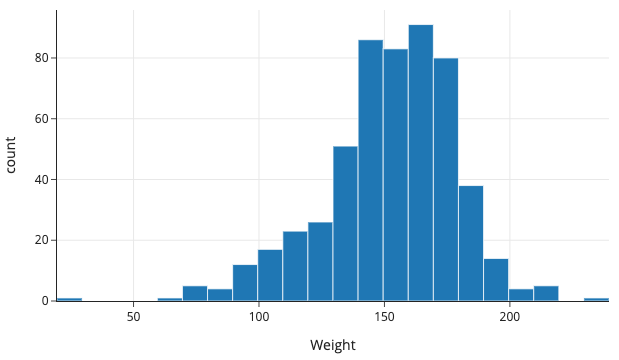

In [9]:
px.histogram(donkeys, x='Weight', nbins=40, width=350, height=250)

It appears there is one very light donkey weighing less than 30 kg. Next, we check the relationship between weight and height to assess the quality of the data for analysis.

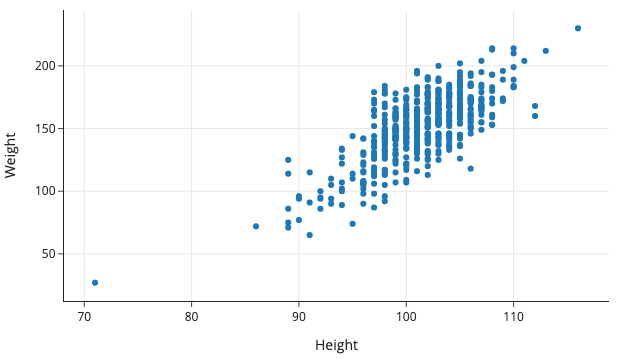

In [10]:
px.scatter(donkeys, x='Height', y='Weight', width=350, height=250)

The small donkey is far from the main concentration of donkeys and would overly influence our models. For this reason, we exclude it. Again, we keep in mind that we may also want to exclude the one or two heavy donkeys, if they appear to overly influence our future model fitting: 

In [10]:
def remove_weight_outliers(donkeys):
    return donkeys[(donkeys['Weight'] >= 40)]

donkeys = (pd.read_csv('data/donkeys.csv')
           .pipe(remove_bcs_outliers)
           .pipe(remove_weight_outliers))

donkeys.shape

(541, 8)

In summary, based on our cleaning and quality checks, we removed three anomalous observations from the data frame. Now, we're nearly ready to begin our exploratory analysis.
Before we proceed, we set aside some of our data as a test set.

## Train-Test Split of the Data

We talked about why it's important to separate out a test set from the training set in {numref}`Chapter %s <ch:risk>`.
A best practice is to separate out a test set early in the analysis, before we explore the data in detail because in EDA we begin to make decisions about what kinds of models to fit and what variables to use in the model. It's important that our test set isn't involved in these decisions so that it imitates how our model would perform with entirely new data.

We divide our data into an 80/20 split, where we use 80\% of the data to explore and build a model. Then, we evaluate the model with the 20\% that has been set aside. We use a simple random sample to split the data frame into the test and train sets. To begin, we randomly shuffle the indices of the data frame:

In [11]:
np.random.seed(42)
n = len(donkeys)
indices = np.arange(n)
np.random.shuffle(indices)
n_train = int(np.round((0.8 * n)))

Next, we assign the first 80\% of the data frame to the training set and the remaining 20% to the test set:  

In [12]:
train_set = donkeys.iloc[indices[:n_train]]
test_set = donkeys.iloc[indices[n_train:]]

Now we're ready to explore the training data and look for useful relationships and distributions that inform our modeling. 